In [1]:
import os
import torch
import pandas as pd
from no_training import get_data
from complete_training_data_processing import CompleteModelsDataProcessor
from model_inspection_funcs import neuron_data_from_image, propagate_data_with_steps

import config
from graph_models import FullGraphModel

%matplotlib inline
import seaborn as sns
blue_yellow = ["#FFD700", "#0000FF"]
# blue_yellow.reverse()
sns.set_palette(blue_yellow)

device = torch.device("cpu")
dtype = torch.float32

num_passes = 4
pairs_num = 100

In [3]:
data_processor = CompleteModelsDataProcessor(
    neurons=config.neurons,
    voronoi_criteria=config.voronoi_criteria,
    random_synapses=config.random_synapses,
    log_transform_weights=config.log_transform_weights,
)

model = FullGraphModel(
    input_shape=data_processor.number_of_synapses,
    num_connectome_passes=config.NUM_CONNECTOME_PASSES,
    decision_making_vector=data_processor.decision_making_vector,
    batch_size=config.batch_size,
    dtype=config.dtype,
    edge_weights=data_processor.synaptic_matrix.data,
    device=device,
    train_edges=config.train_edges,
    train_neurons=config.train_neurons,
    lambda_func=config.lambda_func,
    final_layer=config.final_layer,
    num_classes=len(config.CLASSES),
).to(device)

checkpoint = torch.load("models/v37ivin2_2024-06-01 00:24.pth", map_location="cpu")
model.load_state_dict(checkpoint["model"])
model.eval()

FullGraphModel(
  (connectome): Connectome()
  (final_fc): Linear(in_features=1, out_features=2, bias=True)
)

In [17]:
connections, shuffled_connections, all_neurons, neuron_data, all_coords = get_data()
connections["weight"] = model.connectome.edge_weight_multiplier.detach()
head_direction = pd.read_csv(
    "adult_data/head_direction_neurons.csv", dtype={"root_id": "string"}
)
neurons_in_coords = all_neurons.merge(all_coords, on="root_id", how="right")[
    ["root_id", "cell_type"]
].fillna("Unknown")

# Set all cell_types with less than "20" samples to "others"
n = 20

counts = neurons_in_coords["cell_type"].value_counts()

small_categories = counts[counts < n].index
neurons_in_coords["cell_type"] = neurons_in_coords["cell_type"].apply(
    lambda x: "others" if x in small_categories else x
)
first_activations = pd.read_csv("hd_first_activation.csv", dtype={"root_id": "string"})
first_activations["first_activation"] = 1

In [12]:
base_dir = "images"
sub_dirs = ["head_rotation"]
sampled_images = [os.path.join(base_dir, sub_dirs[0], a) for a in sorted(os.listdir(f"{base_dir}/{sub_dirs[0]}"))]

In [27]:
propagation = all_coords["root_id"].to_frame()
for i, img in enumerate(sampled_images):
    activated_data = neuron_data_from_image(img, neuron_data)
    new_activation = activated_data[["root_id", "activation"]]
    new_activation = new_activation.merge(first_activations, on="root_id", how="left").fillna(0)
    new_activation["activation"] = (
        new_activation["activation"] + new_activation["first_activation"]
    )
    new_activation = new_activation.drop(columns=["first_activation"])

    if i == 0:
        activation = new_activation.rename(columns={"activation": f"activation_{i}"})
    else:
        activation = activation.merge(new_activation, on="root_id", how="left").fillna(0)
        activation[f"activation_{i}"] = activation[f"activation_{i}"] + activation[f"activation"]
        activation = activation.drop(columns=["activation"])
        # normalize
        activation[f"activation_{i}"] = activation[f"activation_{i}"] / activation[f"activation_{i}"].max()

    activation = propagate_data_with_steps(activation, connections, i)

    propagation = propagation.merge(activation, on="root_id", how="left").fillna(0)

In [28]:
temp = propagation.merge(all_coords, on="root_id", how="left").fillna(0)
hd_conditions = ((temp["x"]  > 418000) & (temp["x"] < 445000) & 
                    (temp["y"] > 150000) & (temp["y"] < 175000) &
                 (temp["z"] > 160000) & (temp["z"] <175000))
head_propagation = temp[hd_conditions]

<Axes: xlabel='x', ylabel='y'>

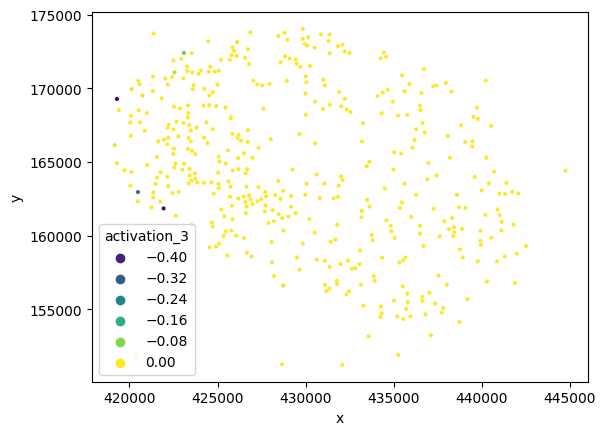

In [29]:
sns.scatterplot(data=head_propagation, x="x", y="y", hue="activation_3", palette="viridis", s=10)

In [30]:
head_propagation.to_csv("head_direction_propagation.csv", index=False)